In [15]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import mmread
import mpmath as mp
from scipy.optimize import minimize
import time
%matplotlib inline

import sys

from scipy.sparse import csr_matrix

In [141]:
import random
from collections import Counter

In [218]:
test_mat = mmread("../data/nipspapersmatrix.mtx")

test_mat.data = np.ones(test_mat.data.size) # change all non-zero values to 1

col_sums = test_mat.sum(axis=0)

col_sums = np.asarray(col_sums)

col_sums = col_sums.flatten() # Col sums ie number of documents where a given word appears

col_sums = col_sums.astype(int) # careful as col_sums has float values not integers

In [266]:
def csr_vappend(a,b):
    """ Takes in 2 csr_matrices and appends the second one to the bottom of the first one. 
    Much faster than scipy.sparse.vstack but assumes the type to be csr and overwrites
    the first matrix instead of copying it. The data, indices, and indptr still get copied."""

    a.data = np.hstack((a.data,b.data))
    a.indices = np.hstack((a.indices,b.indices))
    a.indptr = np.hstack((a.indptr,(b.indptr + a.nnz)[1:]))
    a._shape = (a.shape[0]+b.shape[0],b.shape[1])
    return(a)

def stableibprnd(alpha, sigma, c, N, Jmax):
    Z = np.zeros((1, Jmax))
    m = np.zeros(Jmax) # col sums

    # First object
    
    K = int(np.random.poisson(alpha, 1))
    #print(K)
    Z[0, range(K)] = 1
    Z = csr_matrix(Z)
    m[range(K)] = 1
    for n in range(1, N):
        vec = np.zeros((1, Jmax))
        # Each object picks feature j w.p. (m_j-sigma)/(i-1 + c)
        vec[0,range(K)] = ( np.random.uniform(0, 1, K) < ((m[range(K)]-sigma)/(n  + c)) )
        # New features
        Knew = np.random.poisson((alpha * mp.gamma(1 + c) * mp.gamma(n + c + sigma)) / (mp.gamma(n + 1 + c) * mp.gamma(c + sigma)))
        if Knew>0:
            vec[0, range(K,K+Knew)] = 1
            m[range(K,K+Knew)] = 1
    # Update the counts
        m[range(K)] = m[range(K)]  + vec[0, range(K)]
        #print(Knew)

        K = K + Knew
        if n % 500 ==0:
            print(n)
        vec = csr_matrix(vec)
        csr_vappend(Z, vec)
    return(Z)

In [282]:
a = stableibprnd(10,0.45,0.2,10,1000)

In [279]:
Z_stable = stableibprnd(alpha = 721, c = -0.19, sigma = 0.71, N = 5806, Jmax = 350000)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [295]:
Z_stable.indptr

array([      0,     711,    1419, ..., 4040115, 4040796, 4041513],
      dtype=int32)

In [288]:
Z_unstable = stableibprnd(alpha = 1168, c = 60.3, sigma = 0, N = 5806, Jmax = 400000)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [241]:
alpha = 1168
sigma = 0
c = 60.3
sum([alpha *mp.gamma(1 + c) * mp.gamma(i - 1 + c + sigma) / (mp.gamma(i + c) * mp.gamma(c + sigma)) for i in range(1,5806)])

mpf('322973.13245051116')

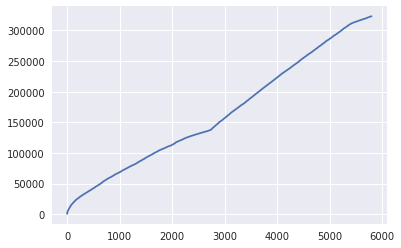

In [221]:
# hacky way, the data is present top to bottom, left to right, so new words correspond to when the column index changes
new_word_ind = np.append(0,np.where(test_mat.col - np.roll(test_mat.col,1)>0)[0])
# find the rows/documents where the new words occur
new_word_rows = test_mat.row[new_word_ind]
# find the table of valuies in the new_word_rows
freq = Counter(new_word_rows)
# sort the rows so that row labelled 0 is counted first
sorted(freq.items(), key=lambda i: i[0])
sns.set()
plt.plot(range(len(list(freq.values()))), np.cumsum(list(freq.values())))